In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234567890',
    database='ecommerce'
)
cur = db.cursor()

# -- Basic Queries

### 1. List all unique cities where customers are located.

In [44]:
query = """ SELECT distinct(customer_city) FROM customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Customer_City"])
df

,Customer_City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### 2. Count the number of orders placed in 2017.

In [47]:
query = """ SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = "2017" """

cur.execute(query)

data = cur.fetchall()

print("Total orders placed in year 2017 : " , data[0][0])

Total orders placed in year 2017 :  180404


### 3. Find the total sales per category.

In [38]:
query = """ SELECT 
    UPPER(products.product_category), 
    ROUND(SUM(payments.payment_value),2) AS Sales
FROM 
    payments 
JOIN 
    order_items ON payments.order_id = order_items.order_id 
JOIN 
    products ON products.product_id = order_items.product_id 
GROUP BY 
    products.product_category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Category" , "Sales"])
df

,Category,Sales
0,PERFUMERY,24323455.67
1,FURNITURE DECORATION,68648466.81
2,TELEPHONY,23370338.43
3,BED TABLE BATH,82202576.21
4,AUTOMOTIVE,40910127.89
...,...,...
69,CDS MUSIC DVDS,57572.64
70,LA CUISINE,139849.44
71,FASHION CHILDREN'S CLOTHING,37712.16
72,PC GAMER,104372.64


### 4. Calculate the percentage of orders that were paid in installments.

In [41]:
query = """ SELECT 
    ((SUM(CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END)) / COUNT(*)) * 100 as order_installments
FROM
    payments; """

cur.execute(query)

data = cur.fetchall()

print("The percentage of orders that were paid in installments :" ,data[0][0])

The percentage of orders that were paid in installments : 99.9981


### 5. Count the number of customers from each state.

    Customers_Count Customer_state
0            166984             SP
4             51408             RJ
2             46540             MG
5             21864             RS
3             20180             PR
1             14548             SC
9             13520             BA
13             8560             DF
8              8132             ES
7              8080             GO
15             6608             PE
12             5344             CE
6              3900             PA
16             3628             MT
10             2988             MA
11             2860             MS
21             2144             PB
23             1980             PI
14             1940             RN
19             1652             AL
25             1400             SE
22             1120             TO
20             1012             RO
17              592             AM
24              324             AC
18              272             AP
26              184             RR


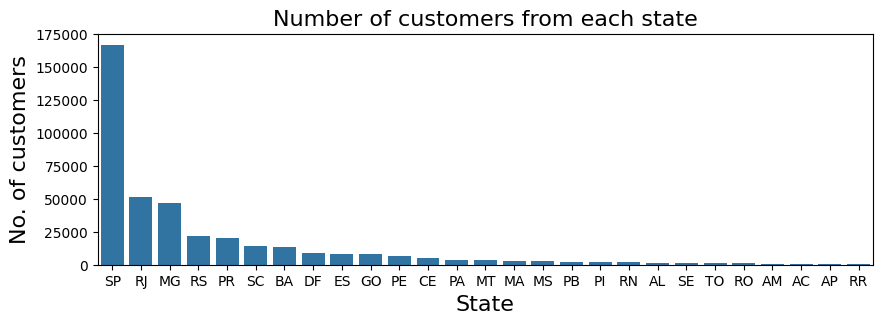

In [66]:
query = """ SELECT 
    COUNT(customer_id), customer_state
FROM
    customers
GROUP BY customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Customers_Count" , "Customer_state"])
df = df.sort_values(by = "Customers_Count" , ascending = False)
print(df)

plt.figure(figsize = [10,3])
sns.barplot(data = df , x = "Customer_state" , y = "Customers_Count")
plt.title("Number of customers from each state",fontsize = 16)
plt.xlabel("State",fontsize = 16)
plt.ylabel("No. of customers",fontsize = 16)
plt.show()

# -- Intermediate Queries

### 1. Calculate the number of orders per month in 2018.

   Order_Count Month(2018)
0        25168        July
1        26048      August
2        26912    February
3        24668        June
4        28844       March
5        29076     January
6        27492         May
7        27756       April
8           64   September
9           16     October


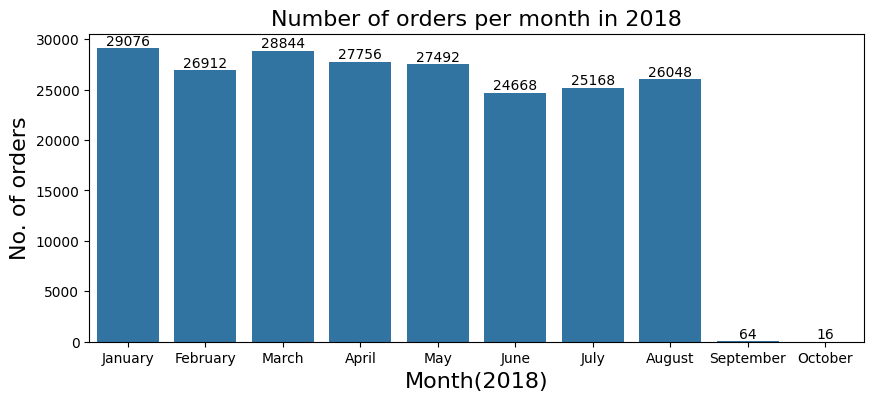

In [71]:
query = """ SELECT 
    COUNT(order_id), MONTHNAME(order_purchase_timestamp)
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = '2018'
GROUP BY MONTHNAME(order_purchase_timestamp); """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Order_Count" , "Month(2018)"])
print(df)

plt.figure(figsize = [10,4])
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October']

ax = sns.barplot(data = df , x = "Month(2018)" , y = "Order_Count" , order = months) 
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018",fontsize = 16)
plt.xlabel("Month(2018)",fontsize = 16)
plt.ylabel("No. of orders",fontsize = 16)
plt.show()

### 2. Find the average number of products per order, grouped by customer city.

In [77]:
query = """ WITH count_per_order AS (
    SELECT 
        orders.order_id,
        orders.customer_id,
        COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT 
    customers.customer_city,
    ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY average_orders DESC;
 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Customer_City" , "Avg_products/order"])
df

,Customer_City,Avg_products/order
0,padre carvalho,112.00
1,celso ramos,104.00
2,datas,96.00
3,candido godoi,96.00
4,matias olimpio,80.00
...,...,...
4105,sao mamede,16.00
4106,sambaiba,16.00
4107,japaratuba,16.00
4108,tuiuti,16.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [3]:
query = """ SELECT 
    UPPER(products.product_category), 
    ROUND((SUM(payments.payment_value) / (SELECT SUM(payments.payment_value) FROM payments)) * 100, 2) 
    AS total_revenue
FROM 
    payments 
JOIN 
    order_items ON payments.order_id = order_items.order_id 
JOIN 
    products ON products.product_id = order_items.product_id 
GROUP BY 
    products.product_category
ORDER BY total_revenue DESC; """

cur.execute(query)

data = cur.fetchall() 

df = pd.DataFrame(data ,columns = ["Product Category" , "Total_Revenue(%)"]) 
df

,Product Category,Total_Revenue(%)
0,BED TABLE BATH,267.44
1,HEALTH BEAUTY,258.82
2,COMPUTER ACCESSORIES,247.57
3,FURNITURE DECORATION,223.34
4,WATCHES PRESENT,223.19
...,...,...
69,PC GAMER,0.34
70,HOUSE COMFORT 2,0.27
71,CDS MUSIC DVDS,0.19
72,FASHION CHILDREN'S CLOTHING,0.12


### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [29]:
import numpy as np

query = """ SELECT 
    products.product_category,
    COUNT(order_items.product_id) AS Product_count,
    ROUND(AVG(order_items.price)) AS Avg_order_item_price
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category
ORDER BY Avg_order_item_price DESC
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Product Category", "Product Count" , "Avg Item Price"]) 
print(df)

arr1 = df["Product Count"]
arr2 = df["Avg Item Price"]

a = np.corrcoef([arr1 ,arr2]) 
print("The correlation between product price and the no of times a product has been purchased is :",a[0][1])
print("Conclusion : There is no impact of price on the product. There is negligible impact.")

               Product Category  Product Count  Avg Item Price
0                           PCs           5075          1098.0
1   HOUSE PASTALS OVEN AND CAFE           1900           624.0
2                  ELECTRICES 2           5950           476.0
3     Agro Industria e Comercio           5300           342.0
4           musical instruments          17000           282.0
..                          ...            ...             ...
69                  Drink foods           6950            55.0
70               cds music dvds            350            52.0
71              Hygiene diapers            975            40.0
72                      flowers            825            34.0
73              House Comfort 2            750            25.0

[74 rows x 3 columns]
The correlation between product price and the no of times a product has been purchased is : -0.1064395024937515
Conclusion : There is no impact of price on the product. There is negligible impact.


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

                          Seller_ID  Total_Revenue  Rank
0  7c67e1448b00f6e969d365cea6b010ab    12679172.68     1
1  1025f0e2d44d7041d6cf58b6550e0bfa     7705551.00     2
2  4a3ca9315b744ce9f8e9374361493884     7531131.74     3
3  1f50f920176fa81dab994f9023523100     7256335.50     4
4  53243585a1d6dc2643021fd1853d8905     7122577.01     5
5  da8622b14eb17ae2831f4ac5b9dab84a     6805482.98     6
6  4869f7a5dfa277a7dca6462dcf3b52b2     6604153.02     7
7  955fee9216a65b617aa5c0531780ce60     5908057.51     8
8  fa1c13f2614d7b5c4749cbc52fecda94     5162830.75     9
9  7e93a43ef30c4f03f38b393420bc753a     4628355.24    10


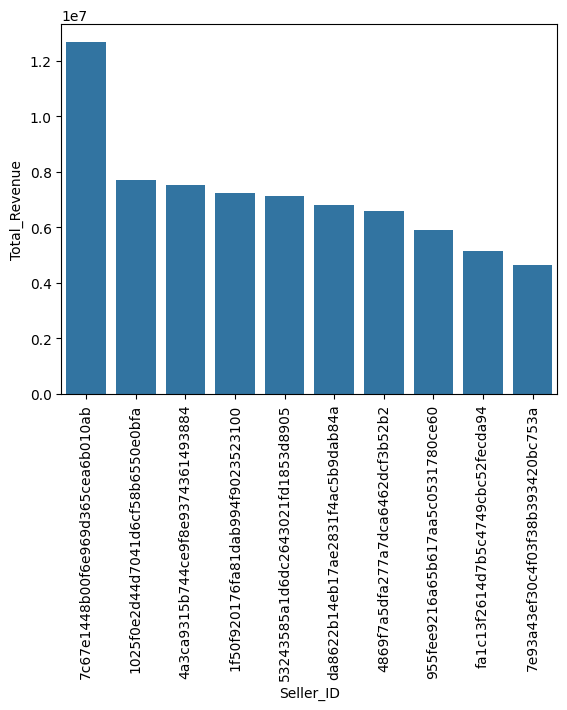

In [40]:
query = """ SELECT 
    a.seller_id, 
    ROUND(a.total_revenue,2),
    DENSE_RANK() OVER (ORDER BY a.total_revenue DESC) AS revenue_rank
FROM 
(SELECT 
    SUM(payments.payment_value) AS total_revenue,
    order_items.seller_id
FROM
    payments
        JOIN
    order_items ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) as a; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Seller_ID" , "Total_Revenue" , "Rank"]) 
df = df.head(10)
print(df)

sns.barplot(data = df ,x= "Seller_ID", y ="Total_Revenue" ) 
plt.xticks(rotation = 90)
plt.show()

# -- Advanced Queries

### 1. Calculate the moving average of order values for each customer over their order history.

In [71]:
query = """SELECT 
    customer_id, 
    order_purchase_timestamp, 
    payment,
    AVG(payment) OVER (
        PARTITION BY customer_id 
        ORDER BY order_purchase_timestamp
        ROWS BETWEEN 10 PRECEDING AND CURRENT ROW
    ) AS mov_avg
FROM (
    SELECT 
        orders.customer_id, 
        orders.order_purchase_timestamp, 
        payments.payment_value AS payment
    FROM 
        payments 
    JOIN 
        orders ON payments.order_id = orders.order_id
) AS a;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer_ID","Order_time", "Payment", "Moving_avg"])
df

,Customer_ID,Order_time,Payment,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
2597145,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2597146,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2597147,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2597148,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


### 2. Calculate the cumulative sales per month for each year.

In [68]:
query = """ SELECT 
    order_year,
    order_month,
    order_month_name,
    total_revenue,
    ROUND(SUM(total_revenue) OVER (
        ORDER BY order_year, order_month
    ),2) AS cumulative_sales
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS order_year,
        MONTH(orders.order_purchase_timestamp) AS order_month,   
        MONTHNAME(orders.order_purchase_timestamp) AS order_month_name,
        ROUND(SUM(payments.payment_value),2) AS total_revenue
    FROM 
        payments 
    JOIN 
        orders ON payments.order_id = orders.order_id
    GROUP BY 
        order_year,
        order_month,
        order_month_name
    ORDER BY 
        order_year ASC,
        order_month ASC
) AS sales_data;
"""

cur.execute(query) 
data = cur.fetchall()
df = pd.DataFrame(data ,columns = ["Year","Month","Month_Name","Total_revenue","Cumulative_revenue"]) 
df

,Year,Month,Month_Name,Total_revenue,Cumulative_revenue
0,2016,9,September,6306.00,6.306000e+03
1,2016,10,October,1477262.00,1.483568e+06
2,2016,12,December,490.50,1.484058e+06
3,2017,1,January,3462201.00,4.946260e+06
4,2017,2,February,7297700.24,1.224396e+07
5,2017,3,March,11246589.99,2.349055e+07
6,2017,4,April,10444700.74,3.393525e+07
7,2017,5,May,14822970.50,4.875822e+07
8,2017,6,June,12781909.51,6.154013e+07
9,2017,7,July,14809572.99,7.634970e+07


### 3. Calculate the year-over-year growth rate of total sales.

In [67]:
query = """ WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value),1) AS payment
    FROM 
        payments
    JOIN 
        orders ON payments.order_id = orders.order_id
    GROUP BY 
        years
)
SELECT 
    years,
    payment,
    LAG(payment, 1) OVER (ORDER BY years) AS previous_year,
    ROUND(((payment - LAG(payment ,1) OVER (ORDER BY years)) /
    LAG(payment ,1) OVER (ORDER BY years )) *100 ,2) AS YOY_growth
FROM 
    a;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Year","Payment","Previous Year","YOY_growth(%)"])
df

,Year,Payment,Previous Year,YOY_growth(%)
0,2016,1484058.5,NaN,NaN
1,2017,181243668.2,1484058.5,12112.7
2,2018,217494076.3,181243668.2,20.0


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [69]:
query = """ WITH first_orders AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM 
        customers
    JOIN 
        orders ON customers.customer_id = orders.customer_id
    GROUP BY 
        customers.customer_id
),
subsequent_purchases AS (
    SELECT 
        a.customer_id,
        COUNT(DISTINCT orders.order_purchase_timestamp) AS additional_purchases
    FROM 
        first_orders a
    JOIN 
        orders ON a.customer_id = orders.customer_id
    WHERE 
        orders.order_purchase_timestamp > a.first_order
        AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY 
        a.customer_id
),
total_customers AS (
    SELECT COUNT(DISTINCT customer_id) AS total_customer_count
    FROM first_orders
),
retained_customers AS (
    SELECT COUNT(DISTINCT customer_id) AS retained_customer_count
    FROM subsequent_purchases
)
SELECT 
    (retained_customer_count / total_customer_count) * 100 AS retention_rate
FROM 
    total_customers, retained_customers;

"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data ,columns = ["Retention_rate"])
df

,Retention_rate
0,0.0000


### 5. Identify the top 3 customers who spent the most money in each year.

   Years                       Customer_id        Payment  Top(3)
0   2016  a9dc96b027d1252bbac0a9b72d837fc6   35588.751221       1
1   2016  1d34ed25963d5aae4cf3d7f3a4cda173   35018.499756       2
2   2016  4a06381959b6670756de02e07b83815f   30694.500732       3
3   2017  1617b1357756262bfa56ab541c47bc16  341602.001953       1
4   2017  c6e2731c5b391845f6800c97401a43a9  173232.751465       2
5   2017  3fd6777bbce08a352fddd04e4a7cc8f6  168166.503906       3
6   2018  ec5b2ba62e574342386871631fafd3fc  181871.997070       1
7   2018  f48d464a0baaea338cb25f816991ab1f  173055.249023       2
8   2018  e0a2412720e9ea4f26c1ac985f6a7358  120235.998535       3


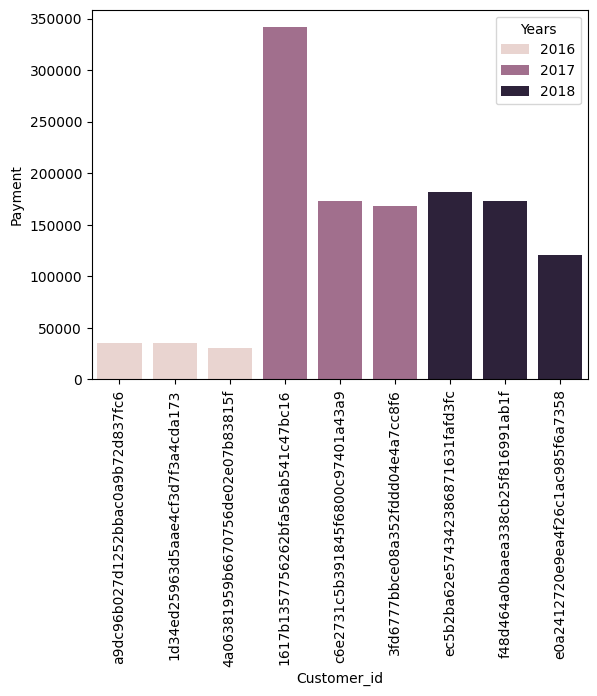

In [73]:
query = """WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(orders.order_purchase_timestamp) 
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM 
        orders 
    JOIN 
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        YEAR(orders.order_purchase_timestamp), 
        orders.customer_id
)
SELECT 
    years,
    customer_id,
    payment,
    d_rank
FROM 
    a
WHERE 
    d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data ,columns = [ "Years","Customer_id","Payment","Top(3)"])
print(df)

sns.barplot(data = df , x = "Customer_id", y = "Payment", hue = "Years")
plt.xticks(rotation = 90)
plt.title("The top 3 customers who spent the most money in each year",fontsize = 16)
plt.show()